<strong><b><font size="5">Análise Estatística e Modelagem Preditiva de Séries Temporais - Em Python</font></b></strong>

<strong><b><font size="4">Forecast Probabilístico para prever Prever a Capacidade com Redes Neurais Recorrentes Autoregressivas - Modelo DeepAR</font></b></strong>

O DeepAR, para previsão de demanda, foi lançado pela Amazon, sendo integrado ao SageMaker. Como tal, você pode usar o DeepAR diretamente no Sagemaker na AWS (que é executado como uma caixa preta). 

O que os autores sugerem que, em vez de ajustar modelos separados para cada série temporal, é criar um modelo global a partir de séries temporais relacionadas para lidar com escalas de grande variação por meio de redimensionamento e amostragem baseada em velocidade. Eles usam uma arquitetura RNN (Recurrent Neural Network) que incorpora uma probabilidade gaussiana / binomial negativa para produzir previsão probabilística e supera a previsão tradicional de item único (os autores demonstram isso em vários conjuntos de dados do mundo real). 

A ideia por trás dessa arquitetura é simples: o objetivo aqui é prever a cada etapa o seguinte (horizonte = 1). Isso significa que a rede deve receber na entrada a observação anterior (no atraso = 1) z_t-1, juntamente com um conjunto de covariáveis opcionais x_i. As informações são propagadas para a camada oculta e até a função de verossimilhança (que é uma função de pontuação usada no nível de uma função de perda). A função de probabilidade pode ser binomial gaussiana ou negativa. O erro é calculado usando a parametrização atual da probabilidade. Facilmente, isso é representado por mu e sigma no caso de uma probabilidade gaussiana. Isso significa que, durante a execução do backpropagation, estamos ajustando os parâmetros de rede (pesos w) que alteram a parametrização de todos os exemplos. 

Aqui está o paper do modelo: <a href="https://arxiv.org/abs/1704.04110">DeepAR: Probabilistic Forecasting with Autoregressive Recurrent Networks</a>

O DeepAR pode ser implementado com o **GluonTS**.

Gluon Time Series é uma biblioteca para modelagem de séries temporais baseada em Deep Learning. O GluonTS simplifica o desenvolvimento e a experimentação de modelos de séries temporais para tarefas comuns, como previsão ou detecção de anomalias. Ele fornece todos os componentes e ferramentas necessários que os Cientistas de Dados precisam para criar rapidamente novos modelos, executar e analisar experimentos com eficiência e avaliar a precisão do modelo.

Gluon Time Series (GluonTS) é o kit de ferramentas Gluon para modelagem probabilística de séries temporais, com foco em modelos baseados em Deep Learning.

O GluonTS fornece utilitários para carregar e iterar conjuntos de dados de séries temporais, modelos prontos pré-treinados e blocos de construção para definir seus próprios modelos e experimentar rapidamente soluções diferentes. Com o GluonTS você pode:

- Treinar e avaliar qualquer um dos modelos internos com seus próprios dados e encontrar rapidamente uma solução para suas tarefas de análise de séries temporais.

- Usar abstrações e blocos de construção fornecidos para criar modelos de séries temporais personalizados e fazar uma comparação rápida com os algoritmos de linha de base.

O GluonTS é executado sobre o framework para Deep Learning MxNet, que foi desenvolvido pela Amazon e hoje é um projeto open-source.

Vamos experimentar o GluonTS em nosso problema de séries temporais. Visite o site oficial aqui:

https://gluon-ts.mxnet.io/

Esta aula considera que você já tem alguma noção sobre o que é Deep Learning e a definição de Deep Learning.

Esse conhecimento pode ser obtido no material gratuito fornecido pela DSA, o <a href="http://www.deeplearningbook.com.br/">Deep Learning Book</a>. 

In [1]:
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import math
import numpy as np
import pandas as pd
import itertools
from pandas import Series
from pandas.tseries.offsets import DateOffset

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns

# Imports para modelagem preditiva
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# MxNet / GluonTS
import mxnet
import gluonts
from mxnet import gpu, cpu
from mxnet.context import num_gpus
from gluonts.dataset.common import ListDataset
from gluonts.trainer import Trainer
from gluonts.dataset.util import to_pandas
from gluonts.model.deepar import DeepAREstimator
from gluonts.distribution.neg_binomial import NegativeBinomialOutput
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

# Imports para formatação dos gráficos
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
#matplotlib.style.use('ggplot')
#%matplotlib inline

from time import time

In [2]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

statsmodels     0.11.1
numpy           1.16.6
matplotlib      3.3.0
seaborn         0.10.1
gluonts         0.5.0
pandas          1.0.5
statsmodels.api 0.11.1
mxnet           1.6.0
Data Science Academy


## Definição do Problema de Negócio

Previsão do número de óbitos de pacientes acima de 50 anos nas internações hospitalares - AIH.

## Conjunto de Dados

Usaremos conjuntos de dados que mostram o número de óbitos de pacientes acima de 50 anos nas internações hospitalares - AIH. Os dados tem registros dos anos de 2010 a 2020.

Será fornecido 1 dataset com 2 colunas, data e número de Óbitos.

Usaremos conjuntos de dados que mostram o número de óbitos de pacientes acima de 50 anos nas internações hospitalares – AIH em Minas Gerais.

Os dados foram baixados do site do Datasus, módulo SIHSUS, tipo de arquivo RD- AIH Reduzida, anos de 2010 a 2020, UF MG, todos os meses:

http://www2.datasus.gov.br/DATASUS/index.php?area=0901&item=1&acao=25

Foi realizado o download de 129 arquivos, com 5.231.829 registros utilizados para preparar um arquivo csv com o agrupamento das internações das pessoas acima de 50 anos que vieram a óbito, perfazendo um total de 3.896 registros diários, 556 registros por semana (excluindo-se a primeira e a última), com data, número e valor total das internações, dados desde 2010.

In [3]:
# Carrega os dados
dataframediario = pd.read_csv("./data/AIH.csv")
dataframediario['Data'] = pd.to_datetime(dataframediario.Data, format = '%d/%m/%Y')
dataframediario = dataframediario.set_index('Data')
# Reamostrando os dados para frequência semanal - Usando o valor médio do número de óbitos de pacientes – AIH
dataframesemanal = dataframediario['QT_INTER'].resample('W').sum()
dataframe = dataframesemanal.to_frame()
dataframe.drop(dataframe.head(1).index,inplace=True) # drop first 1 rows
dataframe.drop(dataframe.tail(1).index,inplace=True) # drop last 1 rows

In [4]:
# Dados
dataframe.head()

,QT_INTER
Data,
2010-01-10,697
2010-01-17,678
2010-01-24,720
2010-01-31,684
2010-02-07,700


In [5]:
# Refinamos os dados para o gráfico da série original
# A variável File_System é nossa variável target 
target = dataframe['QT_INTER']

In [6]:
target

Data
2010-01-10     697
2010-01-17     678
2010-01-24     720
2010-01-31     684
2010-02-07     700
              ... 
2020-08-02    1060
2020-08-09     995
2020-08-16     979
2020-08-23     852
2020-08-30     821
Freq: W-SUN, Name: QT_INTER, Length: 556, dtype: int64

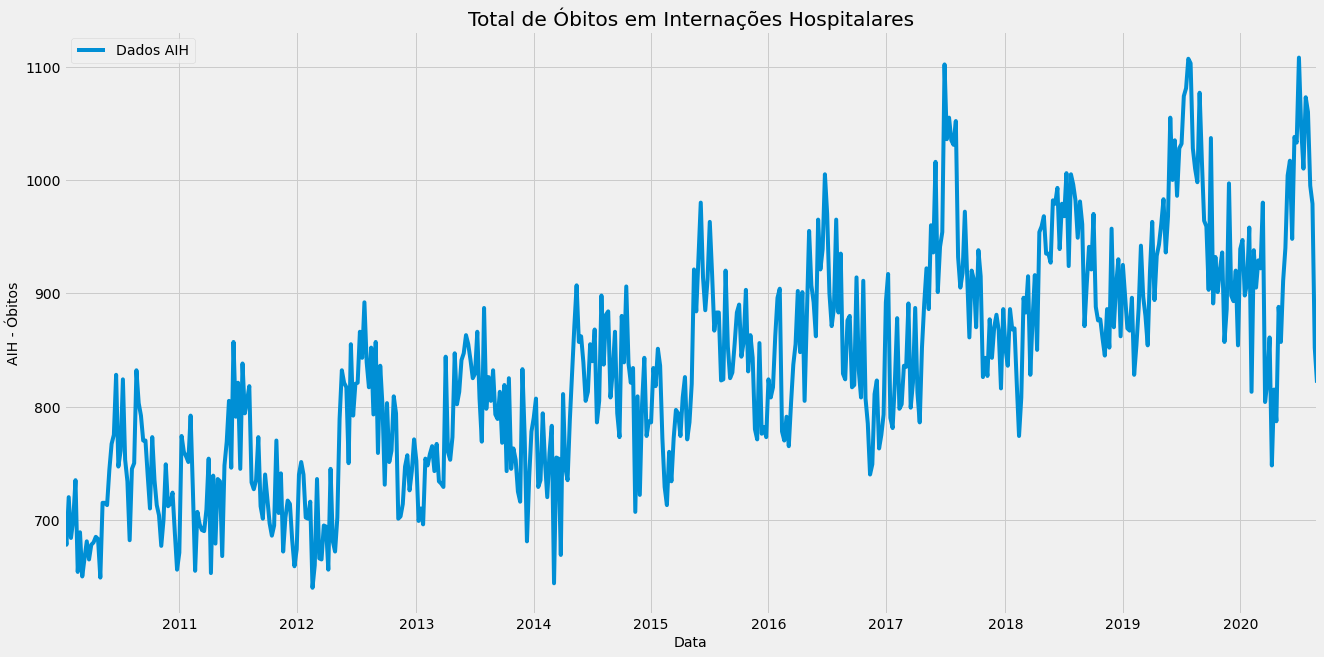

In [7]:
# Plot
target.plot(title = 'Total de Óbitos em Internações Hospitalares', fontsize = 14, label = 'Dados AIH') 
plt.xlabel("Data") 
plt.ylabel("AIH - Óbitos") 
plt.legend(loc = 'best') 
plt.show()

Agora, vamos decompor uma das séries para avaliar seus componentes.

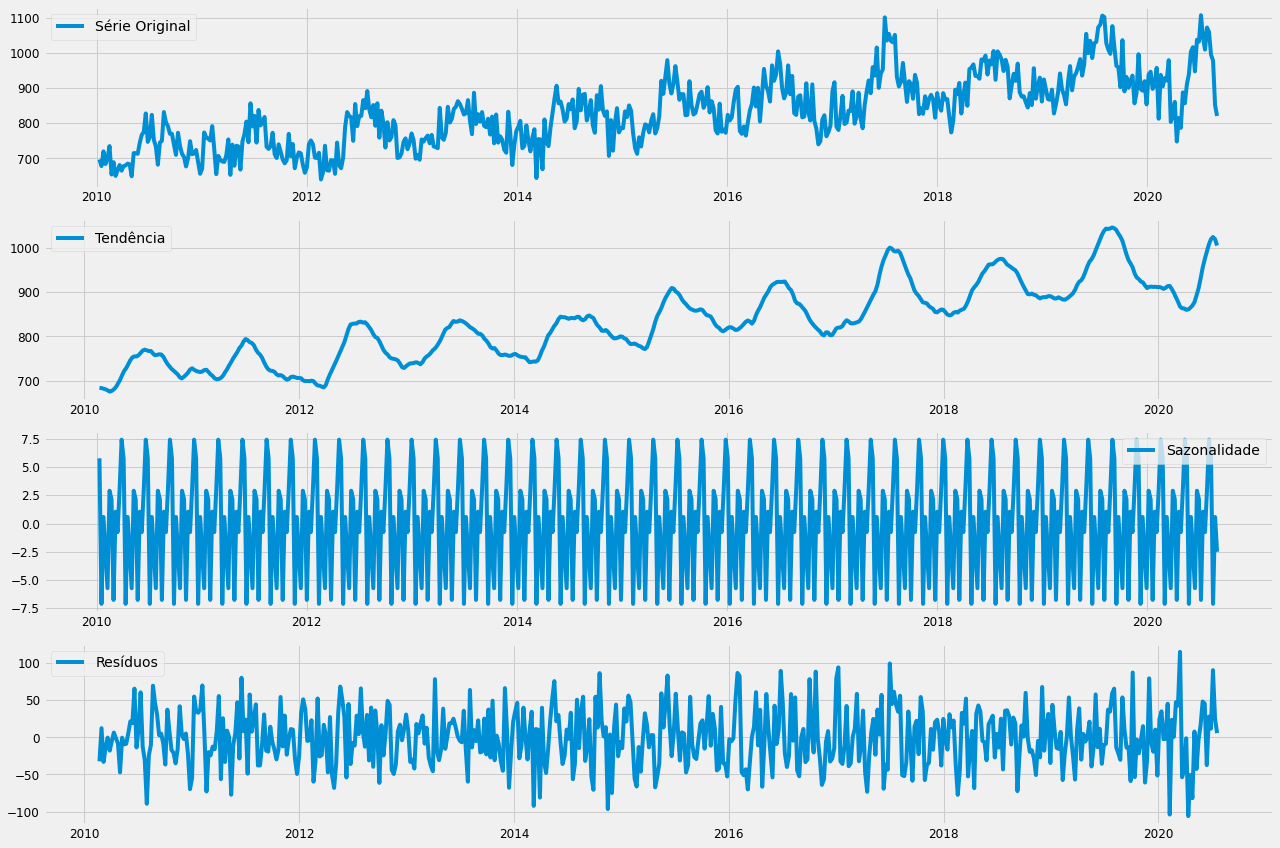

In [8]:
# Decomposição da série temporal de venda média de produtos de tecnologia
decomposition = seasonal_decompose(target, period = 12)
rcParams['figure.figsize'] = 18, 12

# Componentes
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot
plt.subplot(411)
plt.plot(target, label = 'Série Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Tendência')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Sazonalidade')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Resíduos')
plt.legend(loc = 'best')
plt.tight_layout()

Vamos testar a estacionaridade.

In [9]:
# Função para testar a estacionaridade
def testa_estacionaridade(serie):
    
    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = 12).mean()
    rolstd = serie.rolling(window = 12).std()

    # Plot das estatísticas móveis
    plt.figure(figsize = (20, 6))
    orig = plt.plot(serie, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')
    plt.legend(loc = 'best')
    plt.title('Estatísticas Móveis - Média e Desvio Padrão')
    plt.show()
    
    # Teste Dickey-Fuller:
    # Print
    print('\nResultado do Teste Dickey-Fuller:\n')

    # Teste
    dfteste = adfuller(serie, autolag = 'AIC')

    # Formatando a saída
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                               'Valor-p',
                                               'Número de Lags Consideradas',
                                               'Número de Observações Usadas'])

    # Loop por cada item da saída do teste
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)'%key] = value

    # Print
    print (dfsaida)
    
    # Testa o valor-p
    print ('\nConclusão:')
    if dfsaida[1] > 0.05:
        print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente não é estacionária.')
    else:
        print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente é estacionária.')

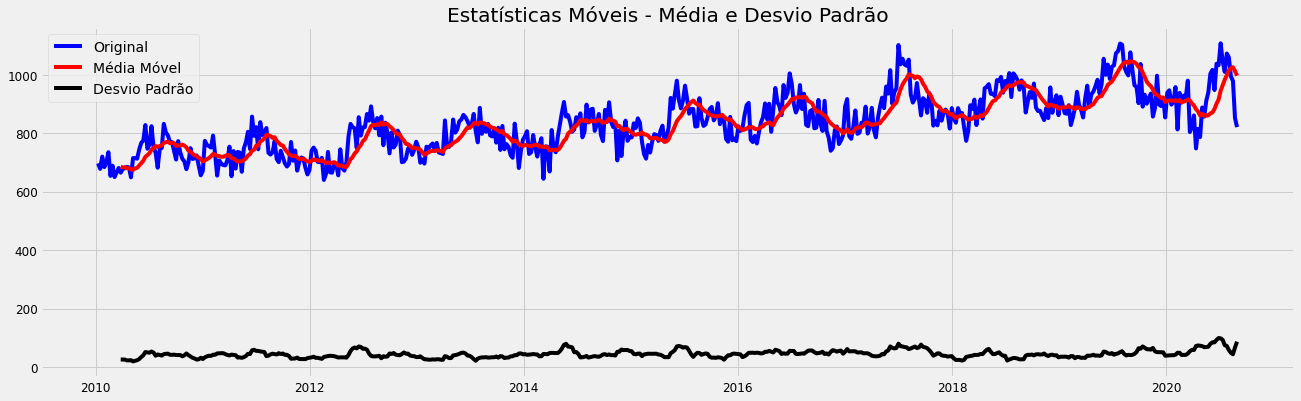


Resultado do Teste Dickey-Fuller:

Estatística do Teste           -6.631458e+00
Valor-p                         5.701116e-09
Número de Lags Consideradas     0.000000e+00
Número de Observações Usadas    5.550000e+02
Valor Crítico (1%)             -3.442187e+00
Valor Crítico (5%)             -2.866762e+00
Valor Crítico (10%)            -2.569551e+00
dtype: float64

Conclusão:

O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [10]:
# Verifica se a série é estacionária
testa_estacionaridade(target)

In [11]:
X = pd.DataFrame(target)

In [12]:
type(X)

pandas.core.frame.DataFrame

In [13]:
# Os primeiros 417 registros da série serão usados como dados de treino
X[:-139]

,QT_INTER
Data,
2010-01-10,697
2010-01-17,678
2010-01-24,720
2010-01-31,684
2010-02-07,700
...,...
2017-12-03,870
2017-12-10,881
2017-12-17,867


In [14]:
# Os últimos 139 registros da série serão usados como dados de teste
X[-139:]

,QT_INTER
Data,
2018-01-07,851
2018-01-14,836
2018-01-21,886
2018-01-28,868
2018-02-04,869
...,...
2020-08-02,1060
2020-08-09,995
2020-08-16,979


In [15]:
# Ajusta o shape, pois agora não temos um objeto pd.Series, 
# mas sim um array NumPy, que é necessário para treinar o modelo LSTM
trainset = X[:-139]
testset = X[-139:]

In [16]:
len(trainset)

417

In [17]:
trainset

,QT_INTER
Data,
2010-01-10,697
2010-01-17,678
2010-01-24,720
2010-01-31,684
2010-02-07,700
...,...
2017-12-03,870
2017-12-10,881
2017-12-17,867


In [37]:
# Função
def plot_forecast(predictor, test_data):
    for test_entry, forecast in zip(test_data, predictor.predict(test_data)):
        to_pandas(test_entry).plot(linewidth = 2)
#        forecast.plot(color = 'g', prediction_intervals = [50.0, 90.0])
        forecast.plot(color = 'g', prediction_intervals = [0, 0])        
    plt.grid(which = 'both')

**Preparando o Dataset para o GluonTS**

O GluonTS não requer um formato específico para um conjunto de dados. Os únicos requisitos são dados iteráveis e ter um campo "target" e "start", onde start representa o ponto inicial do índice da série (que é a data) e target o valor final da série. Só isso.

Aqui estamos usando `gluonts.dataset.common.ListDataset`. Passamos **start** como `pandas.index` e **target** como um conjunto iterável de valores do nosso dataframe pandas, coluna sales.

In [20]:
# Dataset de treino para o GluonTS
training_data = ListDataset([{"start": trainset.index[0], 
                              "target": trainset.QT_INTER[: "2018-12-01"]}], 
                            freq = "W-SUN")

In [21]:
# Dataset de teste para o GluonTS
test_data = ListDataset([{"start": testset.index[0], 
                           "target": testset.QT_INTER[:"2020-09-01"]}], 
                        freq = "W-SUN")

In [22]:
training_data.list_data

[{'start': Timestamp('2010-01-10 00:00:00', freq='W-SUN'),
  'target': Data
  2010-01-10    697
  2010-01-17    678
  2010-01-24    720
  2010-01-31    684
  2010-02-07    700
               ... 
  2017-12-03    870
  2017-12-10    881
  2017-12-17    867
  2017-12-24    816
  2017-12-31    886
  Freq: W-SUN, Name: QT_INTER, Length: 417, dtype: int64}]

In [23]:
test_data.list_data

[{'start': Timestamp('2018-01-07 00:00:00', freq='W-SUN'),
  'target': Data
  2018-01-07     851
  2018-01-14     836
  2018-01-21     886
  2018-01-28     868
  2018-02-04     869
                ... 
  2020-08-02    1060
  2020-08-09     995
  2020-08-16     979
  2020-08-23     852
  2020-08-30     821
  Freq: W-SUN, Name: QT_INTER, Length: 139, dtype: int64}]

**Criando o Modelo:**

Um objeto estimador representa a rede e contém um treinador, que inclui tamanho do lote, inicializador, contexto, taxa de aprendizado e outros hiperparâmetros específicos do treinamento. 

O objeto estimador também inclui a frequência do registro de data e hora, o comprimento da previsão para expressar quantas etapas queremos prever e parâmetros estruturais, como o número de camadas. 

O estimador também inclui crucialmente um método de "treino". O método treino é usado para ajustar um modelo a um determinado conjunto de dados e criando assim um objeto preditivo, que pode ser usado para prever valores.

Nos exemplos a seguir, criamos um estimador DeepAR. Para mais informações sobre o DeepAR, consulte o paper (https://arxiv.org/abs/1704.04110) com base no qual o modelo está sendo desenvolvido.

In [24]:
#print("Number GPU's: " + str(mx.context.num_gpus()))

In [25]:
!C:\Program Files\NVIDIA Corporation\NVSMI\nvidia-smi

Sun Nov 29 14:09:21 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 457.09       Driver Version: 457.09       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 105... WDDM  | 00000000:01:00.0 N/A |                  N/A |
|  0%   58C    P0    N/A /  N/A |    519MiB /  4096MiB |     N/A      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [26]:
# Criação do modelo
# https://gluon-ts.mxnet.io/api/gluonts/gluonts.model.deepar.html
#modelo_gluonts = DeepAREstimator(freq = "M", 
#                                 prediction_length = 30, 
#                                 distr_output = NegativeBinomialOutput(),
#                                 num_layers = 50,
#                                 trainer = Trainer(ctx = "gpu(0)",
#                                                   learning_rate = 1e-3, 
#                                                   epochs = 150,
#                                                   num_batches_per_epoch = 50,
#                                                   batch_size = 32))

In [32]:
# Criação do modelo
# https://gluon-ts.mxnet.io/api/gluonts/gluonts.model.deepar.html
modelo_gluonts = DeepAREstimator(freq = "W-SUN", 
                                 prediction_length = 139, 
#                                 distr_output = NegativeBinomialOutput(),
                                 num_layers = 3,
                                 trainer = Trainer(ctx = "gpu(0)",
                                                   learning_rate = 1e-3, 
                                                   epochs = 150,
                                                   num_batches_per_epoch = 50,
                                                   batch_size = 32))

In [33]:
# Agora fazemos o treinamento
start = time()

modelo_gluonts_predictor = modelo_gluonts.train(training_data = training_data)

print ('\nTempo gasto: %s segundos' % str(time() - start))

  0%|                                                                                                                                     | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|█████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.91it/s, epoch=50/150, avg_epoch_loss=4.65]


100%|████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.90it/s, epoch=100/150, avg_epoch_loss=4.14]


100%|████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.92it/s, epoch=150/150, avg_epoch_loss=3.85]



Tempo gasto: 4018.9704213142395 segundos


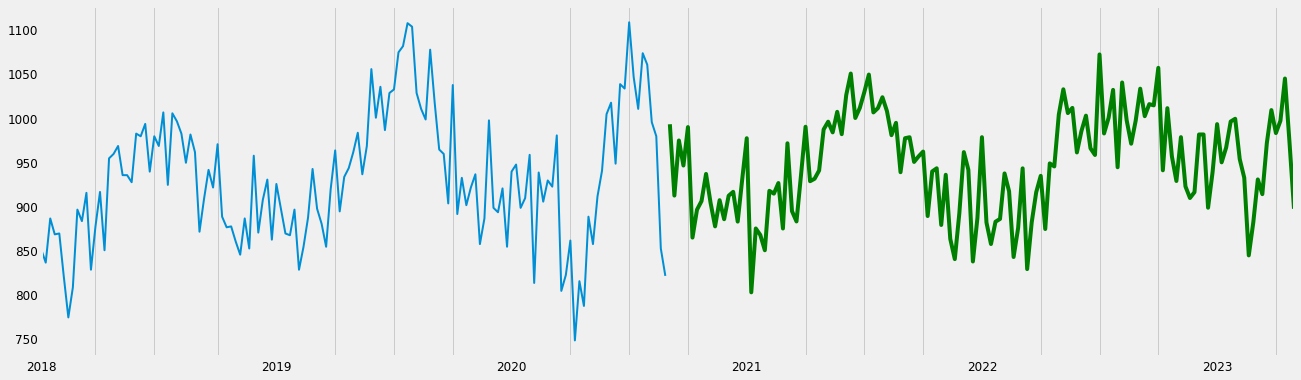

In [38]:
# Vamos plotar o forecast
# Plot
plt.figure(figsize = (20, 6))
plot_forecast(predictor = modelo_gluonts_predictor, test_data = test_data)

O forecast parece acompanhar o padrão da série. Vamos avaliar o modelo.

In [42]:
# Previsões com os dados de teste
forecast_it, ts_it = make_evaluation_predictions(dataset = test_data, 
                                                 predictor = modelo_gluonts_predictor, 
                                                 num_samples = 139)

In [43]:
# Extrai as métricas 
metricas_agregadas, metricas_item = Evaluator()(ts_it, forecast_it, num_series = len(test_data))

Running evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.80s/it]


In [44]:
# Visualiza as métricas
metricas_agregadas

{'MSE': 872698.0143884892,
 'abs_error': 129451.0,
 'abs_target_sum': 129451.0,
 'abs_target_mean': 931.3021582733813,
 'seasonal_error': nan,
 'MASE': nan,
 'MAPE': 1.0,
 'sMAPE': 2.0,
 'OWA': nan,
 'MSIS': nan,
 'QuantileLoss[0.1]': 25890.2,
 'Coverage[0.1]': 0.0,
 'QuantileLoss[0.2]': 51780.4,
 'Coverage[0.2]': 0.0,
 'QuantileLoss[0.3]': 77670.59999999998,
 'Coverage[0.3]': 0.0,
 'QuantileLoss[0.4]': 103560.8,
 'Coverage[0.4]': 0.0,
 'QuantileLoss[0.5]': 129451.0,
 'Coverage[0.5]': 0.0,
 'QuantileLoss[0.6]': 155341.19999999995,
 'Coverage[0.6]': 0.0,
 'QuantileLoss[0.7]': 181231.4,
 'Coverage[0.7]': 0.0,
 'QuantileLoss[0.8]': 207121.6,
 'Coverage[0.8]': 0.0,
 'QuantileLoss[0.9]': 233011.8,
 'Coverage[0.9]': 0.0,
 'RMSE': 934.1830732723053,
 'NRMSE': 1.0030934267394644,
 'ND': 1.0,
 'wQuantileLoss[0.1]': 0.2,
 'wQuantileLoss[0.2]': 0.4,
 'wQuantileLoss[0.3]': 0.5999999999999999,
 'wQuantileLoss[0.4]': 0.8,
 'wQuantileLoss[0.5]': 1.0,
 'wQuantileLoss[0.6]': 1.1999999999999997,
 'wQuan

O RMSE foi bastante alto. Nem mesmo um dos modelos mais avançados da atualidade parece ser suficiente para ajustar essa série. Médias mensais não são a forma ideal de trabalhar com séries temporais, além do fato do volume de dados ser muito baixo.

Vale ressaltar que estamos sendo bem rigorosos na avaliação dos modelos.

O modelo probabilístico autoregressivo, assim como qualquer modelo de Deep Learning, mostra seu brilho quando o volume de dados é realmente alto.

Mas esse modelo DeepAR merece sua atenção. É um dos avanços recentes em Deep Learning.

Como estamos até agora:
    
- Modelo 15 --> Modelo ARMA (4,5) - AIC = 38735.11 e RMSE = 236.8709
- Modelo 16 --> Modelo ARIMA Forcast (5,1,2) - AIC = 39559.670 e RMSE = 459.1013
- Modelo 17 --> Modelo SARIMA (2, 1, 2)x(2, 1, 0, 12) - AIC = 4104.139 e RMSE = 197.0291
- Modelo 18 --> Modelo SARIMA (0, 1, 1)x(0, 1, 1, 12) - AIC = 4131.634 e RMSE = 81.8482
- Modelo 22 --> Modelo LSTM Padrão - MAPE = 10.2775 e RMSE = 120.1346   -   (5 repetições)
- Modelo 22 --> Modelo LSTM Padrão - MAPE = 11.7861 e RMSE = 878868.4191   -   (20 repetições)
- Modelo 23 --> Modelo Stacked LSTM - MAPE = 8.3069 e RMSE = 98.5724   -   (3 repetições)
- Modelo 24 --> Modelo Stacked LSTM Profundo - MAPE = 8.6613 e RMSE = 100.2641 
- Modelo 26 --> Modelo DeepAR - MAPE 1.0 RMSE = 934.1830 


Todas as aulas deste curso podem ser encontradas na timeline da Comunidade no portal da DSA: www.datascienceacademy.com.br

# Fim